In [56]:
################################################################################
# Import modules
#-------------------------------------------------------------------------------
import numpy as np
import numpy.ma as ma
from astropy.table import Table, QTable
from astropy.io import fits
import matplotlib.pyplot as plt

from mapSmoothness_functions import how_smooth

import time

import csv

import os.path
from os import path
################################################################################

In [57]:
MANGA_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/SDSS/dr16/manga/spectro/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v2_4_3/drpall-v2_4_3.fits'
DTable =  Table.read(DRP_FILENAME, format='fits')

# Import the morphology data

In [58]:
MTable = Table.read('manga_visual_morpho-1.0.1.fits',format='fits')

# Plate-IFU of galaxies being fitted

In [60]:
galaxy_ID = []
plate = ['7443','7495','7815','7957']
IFU = ['1901','1902','3701','3702','3703','3704','6101','6102','6103','6104','9101','9102','12701','12702','12703','12704','12705']
for i in range(len(plate)):
    for j in range(len(IFU)):
        galaxy_ID.append(plate[i]+'-'+IFU[j])

In [61]:
f_morph = fits.open('manga_visual_morpho-1.0.1.fits')
morph_data = f_morph[1].data

In [62]:
# Get inclination angles
DTable1 = QTable.read('Master_Table.txt',format='ascii.commented_header')
rat = DTable1['NSA_ba'].data
#phi_deg = DTable1['NSA_phi'].data
#phi_rad = phi_deg*np.pi/180

In [63]:
plate_string = []
ifu_string = []
for i in range(len(DTable1)):
    plate_string.append(str(DTable1['MaNGA_plate'][i]))
    ifu_string.append(str(DTable1['MaNGA_IFU'][i]))

# Check for presence of tidal debris

Tidal = 1 $\rightarrow$ present

Tidal = 0 $\rightarrow$ not present


In [66]:
def getTidal(gal_ID):
    for galaxy in morph_data:
        if galaxy['NAME'] == 'manga-'+gal_ID:
            return galaxy['TIDAL']

In [67]:
Tidal_list = np.zeros(len(galaxy_ID))
for i in range(len(galaxy_ID)):
    Tidal_list[i] = getTidal(galaxy_ID[i])

In [68]:
Tidal_list

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
# Import good and bad fits

In [70]:
def get_fit_sol(nlist):
    del nlist[0]
    del nlist[-3]
    del nlist[-2]
    return nlist

In [71]:
def toFloat(nlist):
    for i in range(len(nlist)):
        nlist[i] = float(nlist[i])
    return nlist

In [72]:
# borrowed from Prof. Kelly Douglass
def find_phi(center_coords, phi_angle, vel_map):
    '''
    Find a point along the semi-major axis that has data to determine if phi
    needs to be adjusted.  (This is necessary because the positive y-axis is
    defined as being along the semi-major axis of the positive velocity side of
    the velocity map.)


    PARAMETERS
    ==========

    center_coords : tuple
        Coordinates of the center of the galaxy

    phi_angle : float
        Initial rotation angle of the galaxy, E of N.  Units are degrees.

    vel_map : masked ndarray of shape (n,n)
        Masked H-alpha velocity map


    RETURNS
    =======

    phi_adjusted : float
        Rotation angle of the galaxy, E of N, that points along the positive
        velocity sector.  Units are radians.
    '''

    # Convert phi_angle to radians
    #phi = phi_angle * np.pi / 180.

    phi = phi_angle

    # Extract "systemic" velocity (velocity at center spaxel)
    v_sys = vel_map[center_coords]

    f = 0.4

    checkpoint_masked = True

    while checkpoint_masked:
        delta_x = int(center_coords[1] * f)
        delta_y = int(delta_x / np.tan(phi))
        semi_major_axis_spaxel = np.subtract(center_coords, (-delta_y, delta_x))

        for i in range(len(semi_major_axis_spaxel)):
            if semi_major_axis_spaxel[i] < 0:
                semi_major_axis_spaxel[i] = 0
            elif semi_major_axis_spaxel[i] >= vel_map.shape[i]:
                semi_major_axis_spaxel[i] = vel_map.shape[i] - 1

        # Check value along semi-major axis
        if vel_map.mask[tuple(semi_major_axis_spaxel)] == 0:
            checkpoint_masked = False
        elif time.time() >= 1000:
            checkpoint_masked = False
        else:
            f *= 0.9

    if vel_map[tuple(semi_major_axis_spaxel)] - v_sys < 0:
        phi_adjusted = phi + np.pi
    else:
        phi_adjusted = phi

    return phi_adjusted

In [73]:
def Galaxy_Data(galaxy_ID):
    '''
    PARAMETERS
    ==========

    galaxy_ID : string
        'Plate-IFU'


    RETURNS
    =======

    physical properties & data of the galaxy

    '''
    plate, IFU = galaxy_ID.split('-')
    '''
    ############################################################################
    # Obtain redshift
    #---------------------------------------------------------------------------
    for i in range(len(DTable2)):
        if DTable2['MaNGA_plate'][i] == int(plate) and DTable2['MaNGA_IFU'][i] == int(IFU):
            redshift = z[i]
            velocity = redshift * c
            distance = (velocity / H_0) * 1E3 #kpc
            scale = 0.5 * (distance) / 206265
    ############################################################################
    '''
    '''
    ############################################################################
    # Obtain inclination
    #---------------------------------------------------------------------------
    incl = 0
    for i in range(len(DTable1)):
        if DTable1['MaNGA_plate'][i] == int(plate) and DTable1['MaNGA_IFU'][i] == int(IFU):
            incl = np.arccos(rat[i])
    ############################################################################
    '''
    '''
    ############################################################################
    # Obtain phi
    #---------------------------------------------------------------------------
    ph = 0
    for i in range(len(DTable1)):
        if DTable1['MaNGA_plate'][i] == int(plate) and DTable1['MaNGA_IFU'][i] == int(IFU):
            ph = phi[i] * np.pi / 180
    ############################################################################
    '''

    ############################################################################
    # Obtaining Data Cubes, Inverse Variances, and Masks
    #---------------------------------------------------------------------------
    #cube = fits.open('manga-' + galaxy_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz')
    cube = fits.open(VEL_MAP_FOLDER + plate + '/' + IFU + '/manga-' + galaxy_ID + '-MAPS-HYB10-GAU-MILESHC.fits.gz')

    r_band = cube['SPX_MFLUX'].data
    Ha_vel = cube['EMLINE_GVEL'].data[18]
    Ha_vel_ivar = cube['EMLINE_GVEL_IVAR'].data[18]
    Ha_vel_mask = cube['EMLINE_GVEL_MASK'].data[18]


    vmasked = ma.array(Ha_vel, mask=Ha_vel_mask)
    ivar_masked = ma.array(Ha_vel_ivar, mask=Ha_vel_mask)

    gshape = vmasked.shape
    ############################################################################

    # Ha flux
    Ha_flux = cube['EMLINE_GFLUX'].data[18]
    Ha_flux_ivar = cube['EMLINE_GFLUX_IVAR'].data[18]
    Ha_flux_mask = cube['EMLINE_GFLUX_MASK'].data[18]
    Ha_flux_masked = ma.array(Ha_flux, mask = Ha_flux_mask)


    ############################################################################
    # Finding the center
    #---------------------------------------------------------------------------
    center_guess = np.unravel_index(ma.argmin(np.abs(vmasked), axis=None), 
                                    vmasked.shape)
    x_center_guess = center_guess[0]
    y_center_guess = center_guess[1]
    ############################################################################

    #return scale, incl, ph, r_band, Ha_vel, Ha_vel_ivar, Ha_vel_mask, vmasked, gshape, x_center_guess, y_center_guess
    return r_band, Ha_vel, Ha_vel_ivar, Ha_vel_mask, Ha_flux, Ha_flux_ivar, Ha_flux_mask, vmasked, Ha_flux_masked, ivar_masked, gshape, x_center_guess, y_center_guess


In [74]:
################################################################################
# Used files
#-------------------------------------------------------------------------------

MANGA_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/SDSS/dr16/manga/spectro/'
DRP_FILENAME = MANGA_FOLDER + 'redux/v2_4_3/drpall-v2_4_3.fits'
VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'

DTable =  Table.read(DRP_FILENAME, format='fits')
################################################################################

In [75]:
galaxy_ID_complete = DTable['plateifu']

In [76]:
################################################################################
# Get the Mass of stars & redshifts & angular resolution of r50
#-------------------------------------------------------------------------------
m = DTable['nsa_elpetro_mass']
phi = DTable['nsa_elpetro_phi']
z = DTable['nsa_z']
r50_ang = DTable['nsa_elpetro_th50_r']
################################################################################

In [77]:
phi_rad = np.zeros(len(phi))
for i in range(len(phi)):
    phi_rad[i] = phi[i] * np.pi /180

In [78]:
f_good = open('good_fits.csv','r')
f_bad = open('bad_fits.csv','r')
reader_good = csv.reader(f_good)
reader_bad = csv.reader(f_bad)
fit_good = [] 
fit_bad = []

In [79]:
ct_good = 0
for row in reader_good:
    ct_good += 1
    if ct_good >= 2:
        fit_good.append(row)

In [80]:
incl_init_good = np.zeros(len(fit_good))
for i in range(len(fit_good)):
    for j in range(len(DTable1)):
        if fit_good[i][0] == plate_string[j] + '-' + ifu_string[j]:
            incl_init_good[i] = np.arccos(rat[j])

In [81]:
fit_phi_good = np.zeros(len(fit_good))
for i in range(len(fit_good)):
    for j in range(len(phi_rad)):
        if fit_good[i][0] == galaxy_ID_complete[j]:
            fit_phi_good[i] = phi_rad[j]
fit_phi_good

array([1.19480179, 2.35273874, 2.35273874, 1.08712545, 1.08712545,
       1.08712545, 1.79357015, 1.79357015, 1.79357015, 2.42518736,
       2.42518736, 2.42518736, 0.64470368, 0.64470368, 0.64470368,
       0.37927401, 0.37927401, 0.37927401, 0.86444413, 0.86444413,
       2.43766646, 2.46808755, 2.46808755, 2.46808755, 2.86867552,
       1.52315407, 1.52315407, 1.52315407, 1.67793511, 1.67793511,
       1.67793511, 0.96332401, 0.96332401, 2.2685266 , 2.2685266 ,
       2.2685266 , 1.77969478, 1.77969478, 1.77969478, 2.75878959,
       3.11562215, 3.11562215, 3.11562215, 1.89066282, 1.89066282,
       1.89066282, 1.07409482, 1.26043839])

In [82]:
phi_init_good = np.zeros(len(fit_phi_good))
for i in range(len(fit_good)):
    plate, IFU = fit_good[i][0].split('-')
    data_file = VEL_MAP_FOLDER+plate+'/'+IFU+'/manga-'+fit_good[i][0]+'-MAPS-HYB10-GAU-MILESHC.fits.gz'
    r_band, Ha_vel, Ha_vel_ivar, Ha_vel_mask, Ha_flux, Ha_flux_ivar, Ha_flux_mask, vmasked, Ha_flux_masked, ivar_masked, gshape, x_center_guess, y_center_guess = Galaxy_Data(fit_good[i][0])
    center_coord = (x_center_guess, y_center_guess)
    phi_guess = find_phi(center_coord, fit_phi_good[i], vmasked)
    if fit_good[i][0] in ['7443-9101', '7443-3704']:
        phi_guess -= 1.06 * np.pi
    phi_guess = phi_guess % (2 * np.pi)
    phi_init_good[i] = phi_guess
phi_init_good

array([1.19480179, 2.35273874, 2.35273874, 0.89862989, 0.89862989,
       0.89862989, 1.79357015, 1.79357015, 1.79357015, 2.42518736,
       2.42518736, 2.42518736, 0.64470368, 0.64470368, 0.64470368,
       0.37927401, 0.37927401, 0.37927401, 4.00603678, 4.00603678,
       2.43766646, 2.46808755, 2.46808755, 2.46808755, 2.86867552,
       4.66474673, 4.66474673, 4.66474673, 1.67793511, 1.67793511,
       1.67793511, 4.10491666, 4.10491666, 5.41011926, 5.41011926,
       5.41011926, 4.92128744, 4.92128744, 4.92128744, 2.75878959,
       3.11562215, 3.11562215, 3.11562215, 5.03225547, 5.03225547,
       5.03225547, 1.07409482, 1.26043839])

In [83]:
for i in range(len(fit_good)):
    fit_good[i] = toFloat(get_fit_sol(fit_good[i]))

In [84]:
ct_bad = 0
for row in reader_bad:
    ct_bad += 1
    if ct_bad >= 2:
        fit_bad.append(row)

In [85]:
incl_init_bad = np.zeros(len(fit_bad))
for i in range(len(fit_bad)):
    for j in range(len(DTable1)):
        if fit_bad[i][0] == plate_string[j] + '-' + ifu_string[j]:
            incl_init_bad[i] = np.arccos(rat[j])

In [86]:
fit_phi_bad = np.zeros(len(fit_bad))
for i in range(len(fit_bad)):
    for j in range(len(phi_rad)):
        if fit_bad[i][0] == galaxy_ID_complete[j]:
            fit_phi_bad[i] = phi_rad[j]
fit_phi_bad

array([1.19480179, 1.19480179, 2.35273874, 2.32010108, 2.32010108,
       2.32010108, 0.33019011, 0.33019011, 0.33019011, 1.97630613,
       1.97630613, 1.97630613, 1.2350229 , 1.2350229 , 1.2350229 ,
       2.17701899, 2.17701899, 2.17701899, 2.77034367, 2.77034367,
       2.77034367, 0.86444413, 2.43766646, 2.43766646, 1.38032855,
       1.38032855, 1.38032855, 2.86867552, 2.86867552, 1.48238842,
       1.48238842, 1.48238842, 2.28329209, 2.28329209, 2.28329209,
       0.25313383, 0.25313383, 0.25313383, 0.21392326, 0.21392326,
       0.21392326, 2.91569469, 2.91569469, 2.91569469, 0.96332401,
       2.84916274, 2.84916274, 2.84916274, 2.18340689, 2.18340689,
       2.18340689, 1.6786472 , 1.6786472 , 1.6786472 , 2.75878959,
       2.75878959, 1.47248018, 1.47248018, 1.47248018, 2.17752513,
       2.17752513, 2.17752513, 1.43920723, 1.43920723, 1.43920723,
       1.07409482, 1.07409482, 1.26043839, 1.26043839, 2.53116375,
       2.53116375, 2.53116375])

In [87]:
phi_init_bad = np.zeros(len(fit_phi_bad))
for i in range(len(fit_bad)):
    plate, IFU = fit_bad[i][0].split('-')
    data_file = VEL_MAP_FOLDER+plate+'/'+IFU+'/manga-'+fit_bad[i][0]+'-MAPS-HYB10-GAU-MILESHC.fits.gz'
    r_band, Ha_vel, Ha_vel_ivar, Ha_vel_mask, Ha_flux, Ha_flux_ivar, Ha_flux_mask, vmasked, Ha_flux_masked, ivar_masked, gshape, x_center_guess, y_center_guess = Galaxy_Data(fit_bad[i][0])
    center_coord = (x_center_guess, y_center_guess)
    phi_guess = find_phi(center_coord, fit_phi_bad[i], vmasked)
    if fit_bad[i][0] in ['7443-9101', '7443-3704']:
        phi_guess -= 1.06 * np.pi
    phi_guess = phi_guess % (2 * np.pi)
    phi_init_bad[i] = phi_guess
phi_init_bad

array([1.19480179, 1.19480179, 2.35273874, 2.32010108, 2.32010108,
       2.32010108, 0.33019011, 0.33019011, 0.33019011, 1.97630613,
       1.97630613, 1.97630613, 4.18812   , 4.18812   , 4.18812   ,
       5.31861164, 5.31861164, 5.31861164, 2.77034367, 2.77034367,
       2.77034367, 4.00603678, 2.43766646, 2.43766646, 4.5219212 ,
       4.5219212 , 4.5219212 , 2.86867552, 2.86867552, 1.48238842,
       1.48238842, 1.48238842, 2.28329209, 2.28329209, 2.28329209,
       0.25313383, 0.25313383, 0.25313383, 0.21392326, 0.21392326,
       0.21392326, 2.91569469, 2.91569469, 2.91569469, 4.10491666,
       2.84916274, 2.84916274, 2.84916274, 2.18340689, 2.18340689,
       2.18340689, 1.6786472 , 1.6786472 , 1.6786472 , 2.75878959,
       2.75878959, 4.61407284, 4.61407284, 4.61407284, 5.31911779,
       5.31911779, 5.31911779, 1.43920723, 1.43920723, 1.43920723,
       1.07409482, 1.07409482, 1.26043839, 1.26043839, 2.53116375,
       2.53116375, 2.53116375])

In [88]:
for i in range(len(fit_bad)):
    fit_bad[i] = toFloat(get_fit_sol(fit_bad[i]))

In [89]:
A_good = np.zeros(len(fit_good))
Vin_good = np.zeros(len(fit_good))
Rd_good = np.zeros(len(fit_good))
Rh_good = np.zeros(len(fit_good))
incl_good = np.zeros(len(fit_good))
phi_good = np.zeros(len(fit_good))
tidal_good = np.zeros(len(fit_good))
incl_diff_good = incl_good - incl_init_good

In [90]:
for i in range(len(fit_good)):
    A_good[i] = fit_good[i][0]
    Vin_good[i] = fit_good[i][1]
    Rd_good[i] = fit_good[i][3]
    Rh_good[i] = fit_good[i][5]
    incl_good[i] = fit_good[i][6]
    phi_good[i] = fit_good[i][7]
    tidal_good[i] = fit_good[i][-1]
phi_good

array([4.17234096, 2.69855852, 2.65936329, 0.97106493, 0.97856794,
       0.96454062, 1.95227942, 1.96074704, 1.95323992, 1.97449768,
       1.97469545, 1.97606688, 0.71254241, 0.69906934, 0.698224  ,
       0.43797796, 0.39524886, 0.39649696, 3.94303898, 3.94202068,
       2.44007398, 5.64975284, 5.65513272, 5.6528017 , 2.88227533,
       4.24648217, 4.26664806, 4.22689922, 2.00071776, 2.00368572,
       2.04011297, 4.86245899, 4.77685003, 3.24804763, 3.25006665,
       3.23323619, 4.955834  , 4.95154617, 4.95799794, 6.14784927,
       2.88038069, 2.86511318, 2.89970434, 5.02785439, 5.03312217,
       5.02379798, 3.39114741, 1.38931862])

In [91]:
A_bad = np.zeros(len(fit_bad))
Vin_bad = np.zeros(len(fit_bad))
Rd_bad = np.zeros(len(fit_bad))
Rh_bad = np.zeros(len(fit_bad))
incl_bad = np.zeros(len(fit_bad))
phi_bad = np.zeros(len(fit_bad))
tidal_bad = np.zeros(len(fit_bad))
incl_diff_bad = incl_bad - incl_init_bad

In [92]:
for i in range(len(fit_bad)):
    A_bad[i] = fit_bad[i][0]
    Vin_bad[i] = fit_bad[i][1]
    Rd_bad[i] = fit_bad[i][3]
    Rh_bad[i] = fit_bad[i][5]
    incl_bad[i] = fit_bad[i][6]
    phi_bad[i] = fit_bad[i][7]
    tidal_bad[i] = fit_bad[i][-1]
phi_bad

array([4.01407243, 4.03290175, 2.534695  , 2.39181362, 2.37164777,
       2.38479361, 3.52441845, 3.52433604, 3.52335239, 2.15405904,
       2.1547471 , 2.14461957, 3.74756814, 3.7768788 , 3.75092179,
       5.55284058, 4.31536849, 4.3153298 , 2.76638086, 2.78258433,
       2.76130492, 3.94810324, 2.40262881, 2.40345121, 2.37814465,
       2.29464674, 5.45151466, 2.90827527, 2.93065226, 3.89405916,
       4.21587238, 3.88913929, 5.7905829 , 5.86215467, 5.7791369 ,
       0.24551651, 0.22414132, 0.24821308, 0.27722334, 0.28480539,
       0.29404828, 6.05141401, 6.10091747, 6.06863785, 4.74338636,
       2.84090491, 2.84008618, 2.83957344, 1.62454031, 1.62475643,
       1.62501644, 3.77780017, 1.62535311, 3.7622807 , 6.09138458,
       6.09126805, 4.19381669, 4.1816291 , 4.20309064, 5.38793697,
       5.29759038, 5.29712701, 4.36750664, 4.14613002, 4.40442437,
       1.06185172, 1.0618104 , 1.19976242, 1.3665652 , 2.1754493 ,
       5.52158376, 5.58490099])

Text(0.5, 1.0, 'Tidal Presence')

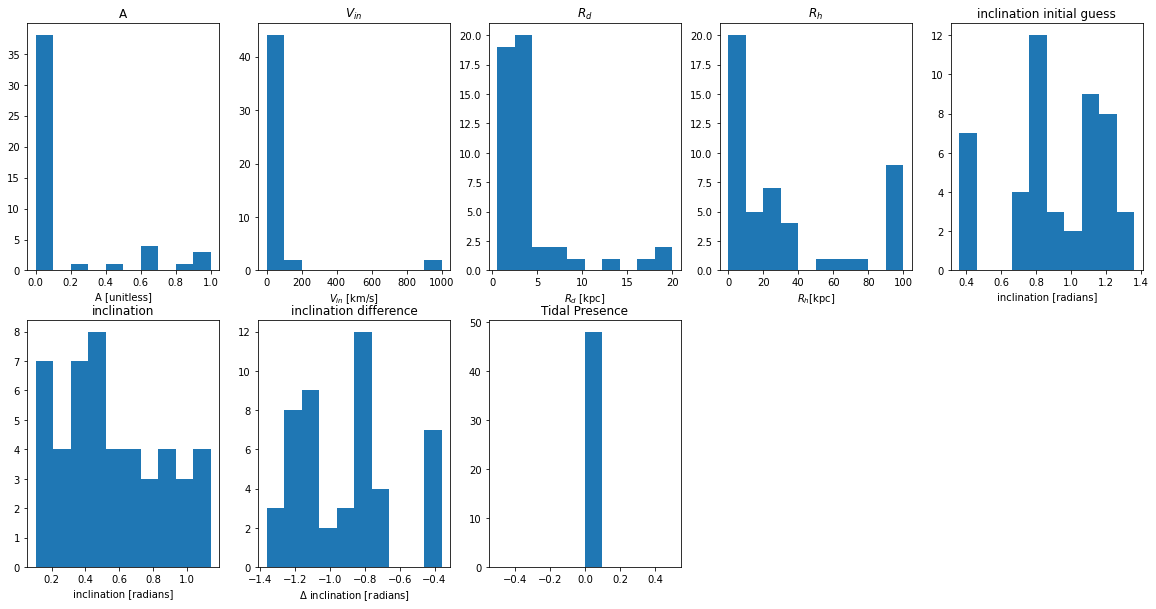

In [93]:
plt.figure(figsize=(20,10))
plt.subplot(251)
plt.hist(A_good)
plt.xlabel('A [unitless]')
plt.title('A')
plt.subplot(252)
plt.hist(Vin_good)
plt.xlabel('$V_{in}$ [km/s]')
plt.title('$V_{in}$')
plt.subplot(253)
plt.hist(Rd_good)
plt.xlabel('$R_d$ [kpc]')
plt.title('$R_d$')
plt.subplot(254)
plt.hist(Rh_good)
plt.xlabel('$R_h$[kpc]')
plt.title('$R_h$')
plt.subplot(255)
plt.hist(incl_init_good)
plt.xlabel('inclination [radians]')
plt.title('inclination initial guess')
plt.subplot(256)
plt.hist(incl_good)
plt.xlabel('inclination [radians]')
plt.title('inclination')
plt.subplot(257)
plt.hist(incl_diff_good)
plt.xlabel('$\Delta$ inclination [radians]')
plt.title('inclination difference')
plt.subplot(258)
plt.hist(tidal_good)
plt.title('Tidal Presence')

Text(0.5, 1.0, 'Tidal Presence')

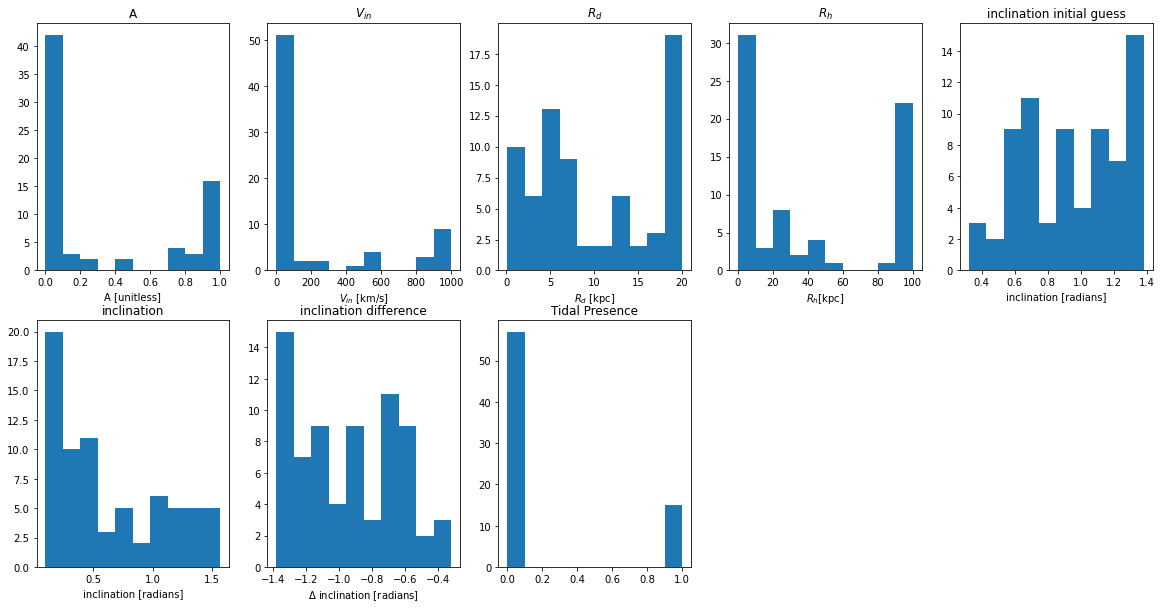

In [94]:
plt.figure(figsize=(20,10))
plt.tight_layout()
plt.subplot(251)
plt.hist(A_bad)
plt.xlabel('A [unitless]')
plt.title('A')
plt.subplot(252)
plt.hist(Vin_bad)
plt.xlabel('$V_{in}$ [km/s]')
plt.title('$V_{in}$')
plt.subplot(253)
plt.hist(Rd_bad)
plt.xlabel('$R_d$ [kpc]')
plt.title('$R_d$')
plt.subplot(254)
plt.hist(Rh_bad)
plt.xlabel('$R_h$[kpc]')
plt.title('$R_h$')
plt.subplot(255)
plt.hist(incl_init_bad)
plt.xlabel('inclination [radians]')
plt.title('inclination initial guess')
plt.subplot(256)
plt.hist(incl_bad)
plt.xlabel('inclination [radians]')
plt.title('inclination')
plt.subplot(257)
plt.hist(incl_diff_bad)
plt.xlabel('$\Delta$ inclination [radians]')
plt.title('inclination difference')
plt.subplot(258)
plt.hist(tidal_bad)
plt.title('Tidal Presence')

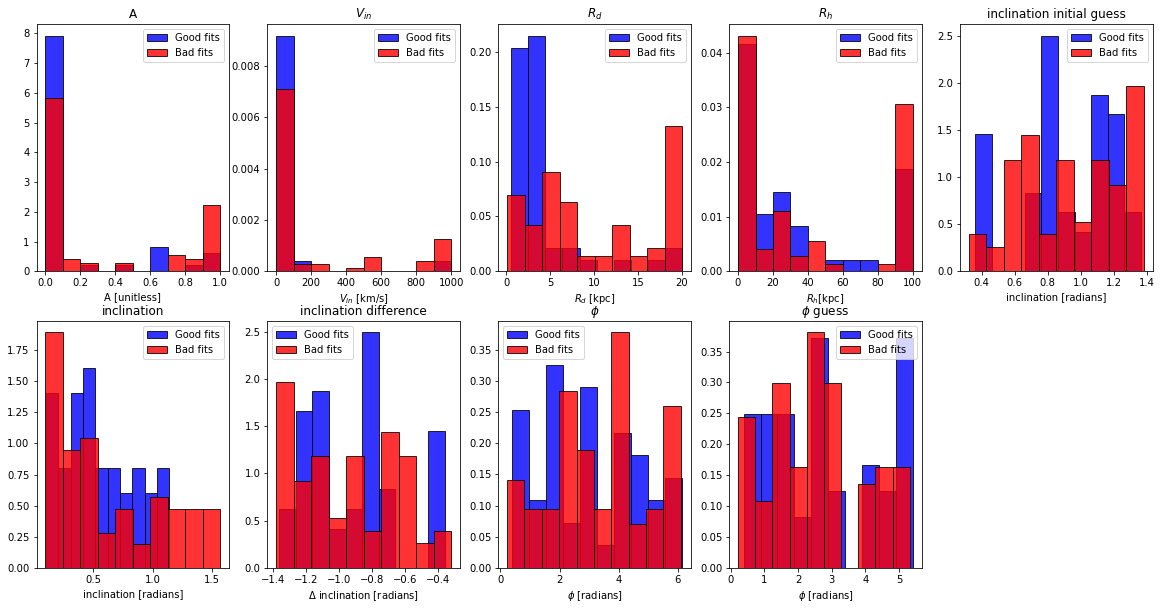

In [95]:
# Plotting the distributions of good and bad fits together. 

plt.figure(figsize=(20,10))

kwargs = dict(histtype='barstacked', alpha=0.8, density=True, bins=10, ec="k")

plt.subplot(251)
plt.hist(A_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(A_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('A [unitless]')
plt.title('A')
plt.legend()
plt.subplot(252)
plt.hist(Vin_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(Vin_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('$V_{in}$ [km/s]')
plt.title('$V_{in}$')
plt.legend()
plt.subplot(253)
plt.hist(Rd_good,**kwargs, color = 'b', label = 'Good fits')
plt.hist(Rd_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('$R_d$ [kpc]')
plt.title('$R_d$')
plt.legend()
plt.subplot(254)
plt.hist(Rh_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(Rh_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('$R_h$[kpc]')
plt.title('$R_h$')
plt.legend()
plt.subplot(255)
plt.hist(incl_init_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(incl_init_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('inclination [radians]')
plt.title('inclination initial guess')
plt.legend()
plt.subplot(256)
plt.hist(incl_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(incl_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('inclination [radians]')
plt.title('inclination')
plt.legend()
plt.subplot(257)
plt.hist(incl_diff_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(incl_diff_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('$\Delta$ inclination [radians]')
plt.title('inclination difference')
plt.legend()
plt.subplot(258)
plt.hist(phi_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(phi_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('$\phi$ [radians]')
plt.title('$\phi$')
plt.legend()
plt.subplot(259)
plt.hist(phi_init_good, **kwargs, color = 'b', label = 'Good fits')
plt.hist(phi_init_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.xlabel('$\phi$ [radians]')
plt.title('$\phi$ guess')
plt.legend()

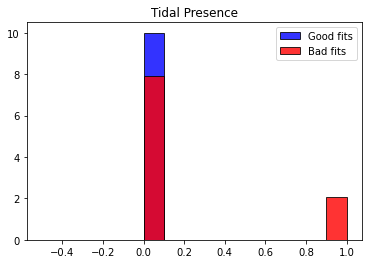

In [96]:
plt.hist(tidal_good,**kwargs, color = 'b', label = 'Good fits')
plt.hist(tidal_bad, **kwargs, color = 'r', label = 'Bad fits')
plt.title('Tidal Presence')
plt.legend()

A higher portion of the bad fits are fitting for a bulge (in comparison to the good fits)

[Text(0.5, 15.000000000000028, '$R_d$ [kpc]'),
 Text(20.625, 0.5, '$R_h$ [kpc]'),
 Text(0.5, 1.0, '$R_h$ vs $R_d$ Bad')]

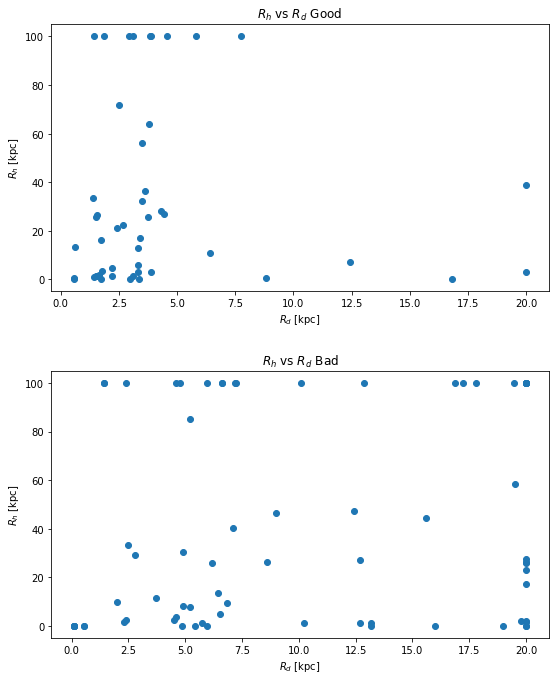

In [97]:

fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)
axs[0].scatter(Rd_good, Rh_good)
axs[0].set(xlabel='$R_d$ [kpc]',ylabel='$R_h$ [kpc]',title='$R_h$ vs $R_d$ Good')
axs[1].scatter(Rd_bad, Rh_bad)
axs[1].set(xlabel='$R_d$ [kpc]',ylabel='$R_h$ [kpc]',title='$R_h$ vs $R_d$ Bad')

The correlation is not very clear. However, the two parameters seem to be more scattered for the bad fits.

[Text(0.5, 15.000000000000028, 'A'),
 Text(20.625, 0.5, '$R_d$ [kpc]'),
 Text(0.5, 1.0, '$R_d$ vs A Bad')]

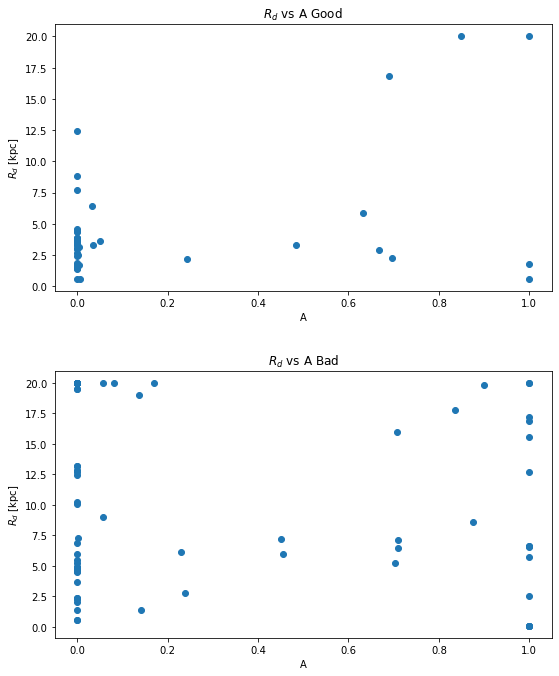

In [98]:
fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)
axs[0].scatter(A_good, Rd_good)
axs[0].set(xlabel='A',ylabel='$R_d$ [kpc]',title='$R_d$ vs A Good')
axs[1].scatter(A_bad, Rd_bad)
axs[1].set(xlabel='A',ylabel='$R_d$ [kpc]',title='$R_d$ vs A Bad')

A is relatively more scattered for the bad fits $\rightarrow$ trying to fit a bulge

[Text(0.5, 15.000000000000028, 'inclination'),
 Text(20.625, 0.5, 'inclination initial guess'),
 Text(0.5, 1.0, 'inclination vs initial guess Bad')]

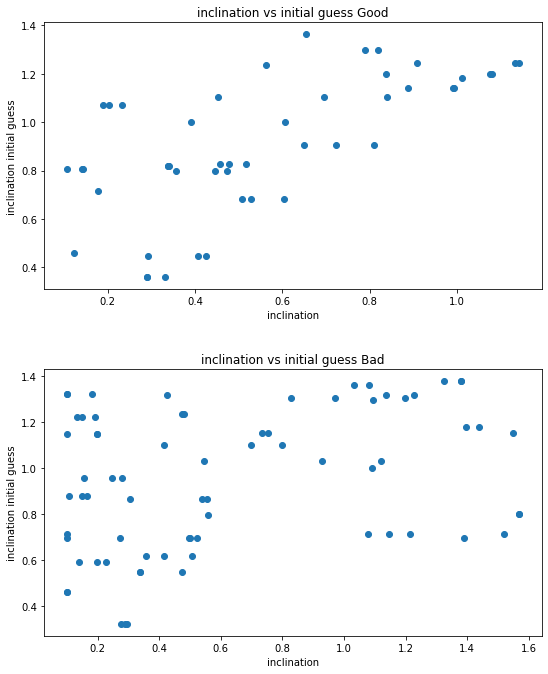

In [99]:
fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)
axs[0].scatter(incl_good, incl_init_good)
axs[0].set(xlabel='inclination',ylabel='inclination initial guess',title='inclination vs initial guess Good')
axs[1].scatter(incl_bad, incl_init_bad)
axs[1].set(xlabel='inclination',ylabel='inclination initial guess',title='inclination vs initial guess Bad')

[Text(0.5, 15.000000000000028, 'inclination'),
 Text(20.625, 0.5, 'inclination difference'),
 Text(0.5, 1.0, 'inclination vs difference Bad')]

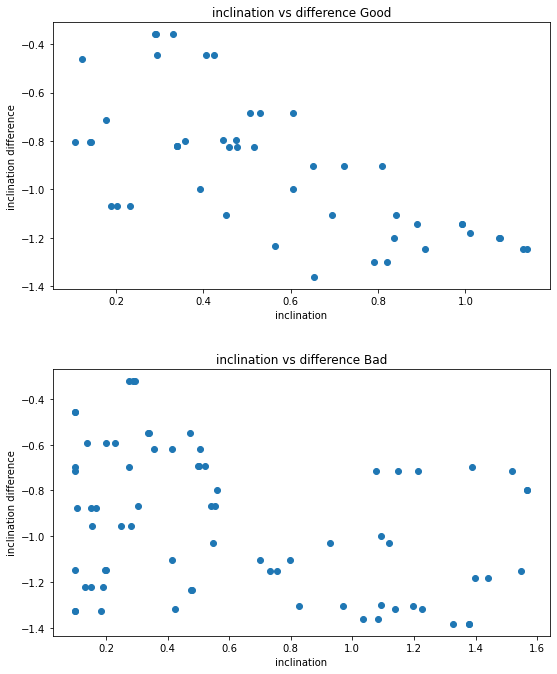

In [100]:
fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)
axs[0].scatter(incl_good, incl_diff_good)
axs[0].set(xlabel='inclination',ylabel='inclination difference',title='inclination vs difference Good')
axs[1].scatter(incl_bad, incl_diff_bad)
axs[1].set(xlabel='inclination',ylabel='inclination difference',title='inclination vs difference Bad')

[Text(0.5, 15.000000000000028, 'phi [radians]'),
 Text(20.625, 0.5, 'phi init [radians]'),
 Text(0.5, 1.0, 'phi vs phi init Bad')]

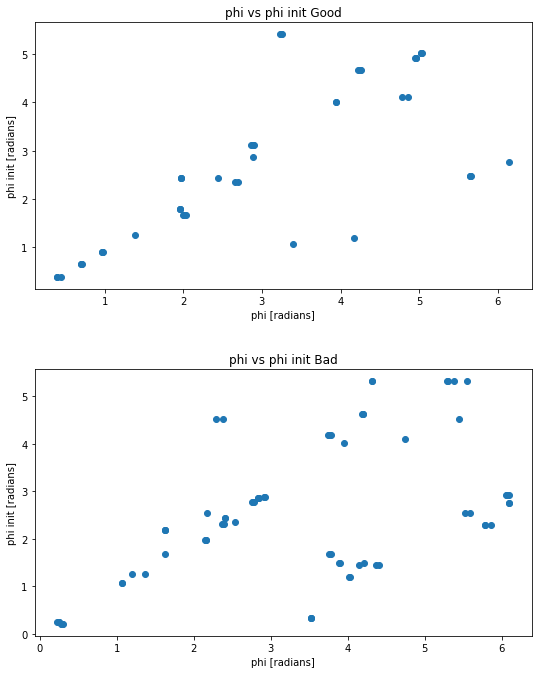

In [101]:
fig, axs = plt.subplots(2)
fig.tight_layout()
fig.set_figheight(10)
fig.set_figwidth(8)
axs[0].scatter(phi_good, phi_init_good)
axs[0].set(xlabel='phi [radians]',ylabel='phi init [radians]',title='phi vs phi init Good')
axs[1].scatter(phi_bad, phi_init_bad)
axs[1].set(xlabel='phi [radians]',ylabel='phi init [radians]',title='phi vs phi init Bad')

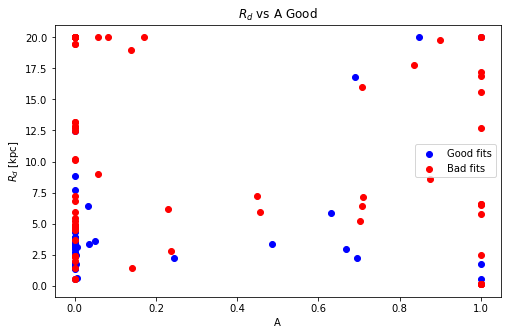

In [102]:
plt.figure(figsize=(8,5))
plt.scatter(A_good, Rd_good, color='b', label='Good fits')
plt.scatter(A_bad, Rd_bad, color='r',label='Bad fits')
plt.xlabel('A')
plt.ylabel('$R_d$ [kpc]')
plt.title('$R_d$ vs A Good')
plt.legend()

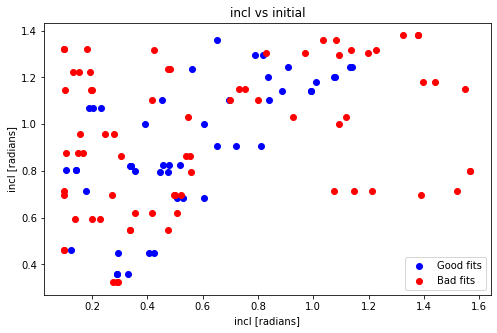

In [103]:
plt.figure(figsize=(8,5))
plt.scatter(incl_good, incl_init_good,color='b',label='Good fits')
plt.scatter(incl_bad, incl_init_bad,color='r',label='Bad fits')
plt.xlabel('incl [radians]')
plt.ylabel('incl [radians]')
plt.title('incl vs initial')
plt.legend()

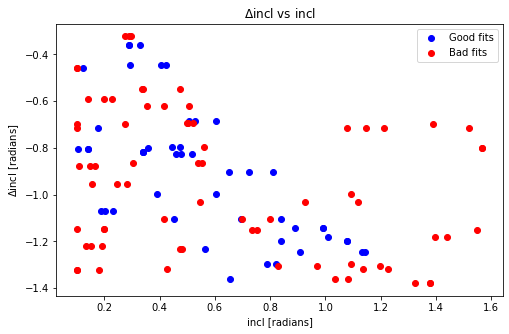

In [104]:
plt.figure(figsize=(8,5))
plt.scatter(incl_good, incl_diff_good,color='b',label='Good fits')
plt.scatter(incl_bad, incl_diff_bad,color='r',label='Bad fits')
plt.xlabel('incl [radians]')
plt.ylabel('$\Delta$incl [radians]')
plt.title('$\Delta$incl vs incl')
plt.legend()

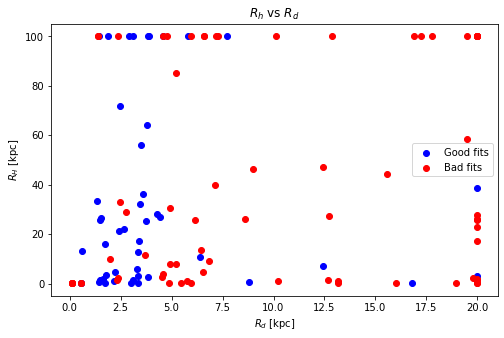

In [105]:
plt.figure(figsize=(8,5))
plt.scatter(Rd_good, Rh_good,color='b',label='Good fits')
plt.scatter(Rd_bad, Rh_bad,color='r',label='Bad fits')
plt.xlabel('$R_d$ [kpc]')
plt.ylabel('$R_H$ [kpc]')
plt.title('$R_h$ vs $R_d$')
plt.legend()

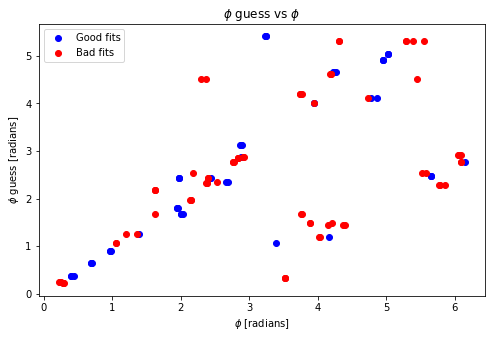

In [106]:
plt.figure(figsize=(8,5))
plt.scatter(phi_good, phi_init_good,color='b',label='Good fits')
plt.scatter(phi_bad, phi_init_bad,color='r',label='Bad fits')
plt.xlabel('$\phi$ [radians]')
plt.ylabel('$\phi$ guess [radians]')
plt.title('$\phi$ guess vs $\phi$')
plt.legend()